# <center>Part II. Facial Classification</center>

# <center>Two-Stage Facial Recognition and Classification Model Using Multi-Task Cascaded Convolutional Neural Networks and Inception-ResNet v1</center>

In [1]:
# General Imports
import numpy as np
import pandas as pd
import os, shutil
import time
import copy

# For Plotting
import matplotlib.pyplot as plt
from PIL import Image

# For Face Classifier
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchsummary import summary
from facenet_pytorch import InceptionResnetV1

# Executive Summary

This technical report outlines the creation of a two-stage model for:
1. Face Detection (Notebook 1)
2. Face Classification (Notebook 2)

The two-stage model utilized state-of-the-art deep learning and tools for both face detection and face classification tasks. For face detection, I used the `MTCNN` (Multi-Task Cascaded Convolutional Neural Networks), which is a deep learning algorithm built into the `facenet_pytorch`, an open-source facial recognition toolkit. For face classification, on the other hand, I used the `InceptionResNetV1` architecture, which was pre-trained on the `vggface2` dataset, a large-scale face recognition dataset. The two-stage model is capable of accurately extracting, cropping, and classifying each Capstone Team Member's face.

Getting to the results, the `face detector` was able to accurately detect faces with impressive prediction scores above **99%** especially for the Capstone Team Member's Faces.

Furthermore, the face classifier was trained for **50 epochs** and achieved an impressive test accuracy of **0.9643**. 

The model's success can be attributed to its use of powerful neural network architectures pre-trained on large datasets. 

This is part 1 of a 2-part Notebook entitled *Two-Stage Facial Recognition and Classification Model Using Multi-Task Cascaded Convolutional Neural Networks and Inception-ResNet v1*.

# Data Prepartion for Cropped Faces

In Notebook 2 (Face Classifier), our goal is to classify the faces that were previously cropped in Notebook 1 (Face Detector). To do this, we need to prepare our data by creating a function that copies images from the source directory to the destination directory based on a specified range of indices per class. This will be used for the train-validation-test split of our data.

In [2]:
# this function can be used to copy images to train, validation, and test dirs
def create_dataset(src, dst, range_, class_):
    """Copy images of class class_ within range_ from src to dst.
    
    Parameters
    ----------
    src : str
        source directory
    dst : str
        destination directory
    range_ : tuple
        tuple of min and max image index to copy
    class_ : str
        image class 
    """
    if os.path.exists(dst):
        # if existing, delete dir to reset
        shutil.rmtree(dst)
    os.makedirs(dst)
    fnames = [f'{class_} ({i}).jpg' for i in range(*range_)]
    file_names = [image_path for image_path in os.listdir(src+'\\')]
    
    for file_ind, fname in enumerate(fnames):
        src_file = os.path.join(src, file_names[file_ind])
        dst_file = os.path.join(dst, fname)
        shutil.copyfile(src_file, dst_file)

Next, we use the function we have created to make a train-validation-test split of our data with the following partition:

- Train - 60%
- Validation - 20%
- Test - 20%


In [3]:
# looping through create_dataset for each class
classes = ['bj', 'greg', 'loraine', 'rozz']

src = 'data\\face_data' # source file

# Number of images per class
files_bj = len([image_path for image_path in os.listdir(src+'\\'+'bj')])
files_greg = len([image_path for image_path in os.listdir(src+'\\'+'greg')])
files_loraine = len([image_path for image_path in os.listdir(src+'\\'+'loraine')])
files_rozz = len([image_path for image_path in os.listdir(src+'\\'+'rozz')])

# Store the number of images per class in a list
files_list = [files_bj, files_greg, files_loraine, files_rozz]

# Specify the train-validation-test partition
partition_train = 0.6
partition_val = 0.2
partition_test = 0.2

# Create the train-val-test partition for all classes
for class_ind, class_ in enumerate(classes):
    
    train_start = 1 # train start
    train_end = round(files_list[class_ind] * partition_train) + 1 # train end
    val_start = train_end # val start
    val_end = val_start + round(files_list[class_ind] * partition_val) # val end
    test_start = val_end # test start
    test_end = files_list[class_ind] + 1 # test end
    
    dst = f'data\\face_class\\train\\{class_}' # train directory
    create_dataset(src+'\\'+class_, dst, range_=(train_start, train_end), class_=class_)

    dst = f'data\\face_class\\validation\\{class_}' # val directory
    create_dataset(src+'\\'+class_, dst, range_=(val_start, val_end), class_=class_)
    
    dst = f'data\\face_class\\test\\{class_}' # test directory
    create_dataset(src+'\\'+class_, dst, range_=(test_start, test_end), class_=class_)

Then, we store the path of our train, validation, and test directories in separate variables for each class.

In [4]:
# train directory per class
train_bj_dir =  'data\\face_class\\train\\bj'
train_greg_dir =  'data\\face_class\\train\\greg'
train_loraine_dir =  'data\\face_class\\train\\loraine'
train_rozz_dir =  'data\\face_class\\train\\rozz'

# val directory per class
validation_bj_dir = 'data\\face_class\\validation\\bj'
validation_greg_dir = 'data\\face_class\\validation\\greg'
validation_loraine_dir = 'data\\face_class\\validation\\loraine'
validation_rozz_dir = 'data\\face_class\\validation\\rozz'

# test directory per class
test_bj_dir = 'data\\face_class\\test\\bj'
test_greg_dir = 'data\\face_class\\test\\greg'
test_loraine_dir = 'data\\face_class\\test\\loraine'
test_rozz_dir = 'data\\face_class\\test\\rozz'

We will now print out the number of images per class in the train-validation-test split to verify if the partition is correct.

In [5]:
#
print('total training bj images:', len(os.listdir(train_bj_dir)))
print('total training greg images:', len(os.listdir(train_greg_dir)))
print('total training loraine images:', len(os.listdir(train_loraine_dir)))
print('total training rozz images:', len(os.listdir(train_rozz_dir)))
print('\n')

print('total validation bj images:', len(os.listdir(validation_bj_dir)))
print('total validation greg images:', len(os.listdir(validation_greg_dir)))
print('total validation loraine images:', len(os.listdir(validation_loraine_dir)))
print('total validation rozz images:', len(os.listdir(validation_rozz_dir)))
print('\n')

print('total test bj images:', len(os.listdir(test_bj_dir)))
print('total test greg images:', len(os.listdir(test_greg_dir)))
print('total test loraine images:', len(os.listdir(test_loraine_dir)))
print('total test rozz images:', len(os.listdir(test_rozz_dir)))

total training bj images: 20
total training greg images: 22
total training loraine images: 18
total training rozz images: 33


total validation bj images: 7
total validation greg images: 7
total validation loraine images: 6
total validation rozz images: 11


total test bj images: 7
total test greg images: 7
total test loraine images: 6
total test rozz images: 11


The dataset is relatively small, with only a total of 155 images for all four (4) classes. We can take a closer look at some sample images (faces) per class.

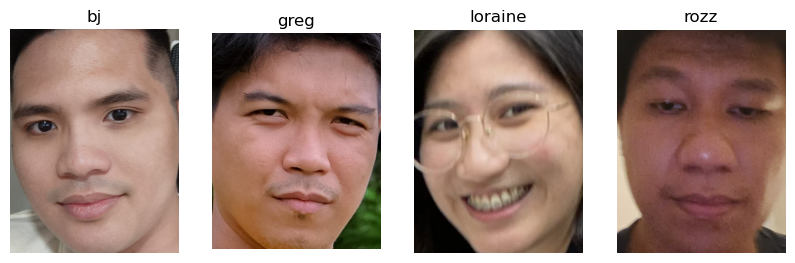

In [6]:
bj = Image.open('data\\face_class\\train\\bj\\bj (9).jpg')
greg = Image.open('data\\face_class\\train\\greg\\greg (17).jpg')
loraine = Image.open('data\\face_class\\train\\loraine\\loraine (8).jpg')
rozz = Image.open('data\\face_class\\train\\rozz\\rozz (16).jpg')

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))
ax1.imshow(bj);
ax1.set_title('bj');
ax1.axis('off');
ax2.imshow(greg);
ax2.set_title('greg');
ax2.axis('off');
ax3.imshow(loraine);
ax3.set_title('loraine');
ax3.axis('off');
ax4.imshow(rozz);
ax4.set_title('rozz');
ax4.axis('off');

Let's take a look at the shape of an image from the bj class to get an idea of what it looks like. We can observe that the image has a shape of `(1750, 1319, 3)`

What does this mean?

This means that the image has a resolution of `1750 pixels in width`, `1319 pixels in height`, and `3 color channels (RGB)`, thus the shape of the image array is `(1750, 1319, 3)`.

**NOTE:**

It's important to note that since the images are taken with different cameras and orientations, their shapes will vary, with the number of color channels being the only constant factor.

In [7]:
img_test = np.asarray(bj)

print("image shape: ", img_test.shape)

image shape:  (1750, 1319, 3)


# Loading the Data

Before training our deep learning model (face classifier), we must first prepare the data by doing the following steps:

1. Define a transformation pipeline that will resize our training images to 224 x 224 pixels in size and converts them into PyTorch tensor format.
2. Load the training data using the `datasets.ImageFolder` function that expects a root directory where the subdirectories for each class images are located.
3. Stack all the image tensors along the 4th dimension, creating a new tensor shape of (3, 224, 224, N) where N is the total number of images in the training data.
4. Compute the means and standard deviations of the image dataset of each color channel across all images.

The means and standard deviations computed will be used to normalize the train, validation, and test splits. Note that we must use the means and standard deviations from the training data.

In [8]:
# train directory
train_dir = "data\\face_class\\train"

# Resizing the images
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms)

# compute for the means and stds (for normalization)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.55647177 0.43785986 0.38737977]
Std. Deviations: [0.2286522  0.19740532 0.18621425]


Next, we define a set of image transformations for the training, validation, and test splits of the data. Note that only the training split has random geometric and photometric transformations applied. This is called data augmentation, which aims to increase the amount of training data and improve the robustness of the trained model by presenting it with a wider variety of training examples.

**In summary:**

**Train**
1. Resize to 224 x 224 pixels
2. Random Horizontal Flip
3. Random Perspective
4. Color Jitter
5. Convert to PyTorch Tensor
6. Normalize by the train mean and std.

**Validation:**
1. Resize to 224 x 224 pixels
2. Convert to PyTorch Tensor
3. Normalize by the train mean and std.

**Test:**
1. Resize to 224 x 224 pixels
2. Convert to PyTorch Tensor
3. Normalize by the train mean and std.

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.6),             
        transforms.RandomPerspective(p=0.5),
        transforms.ColorJitter(brightness=0.5),              
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ])
}

data_dir = 'data\\face_class'

# loading image data using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

# dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                             shuffle=True, drop_last=True)
              for x in ['train', 'validation', 'test']}
# size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# class names
class_names = image_datasets['train'].classes


# Loading the Pretrained Face Classifier Model

We now load the face classifier model. In this case, we choose the Inception-ResNet v1 architecture that has been pre-trained on the VGGFace2 dataset.

Inception-ResNet v1 is a neural network architecture that combines the Inception module and the ResNet module, specifically designed for face recognition tasks. This model has achieved state-of-the-art performance on several benchmarks including the IJB-A and IJB-B face recognition benchmarks. The model can recognize faces across large variations in pose, lighting, and expression, making it well-suited for real-world face recognition applications. See Figure 1.

On the other hand, the VGGFace2 dataset is a large-scale face recognition dataset that contains over 3.3 million face images of over 9,000 identities, with large variations in pose, age, illumination, ethnicity, and profession. See Figure 2.

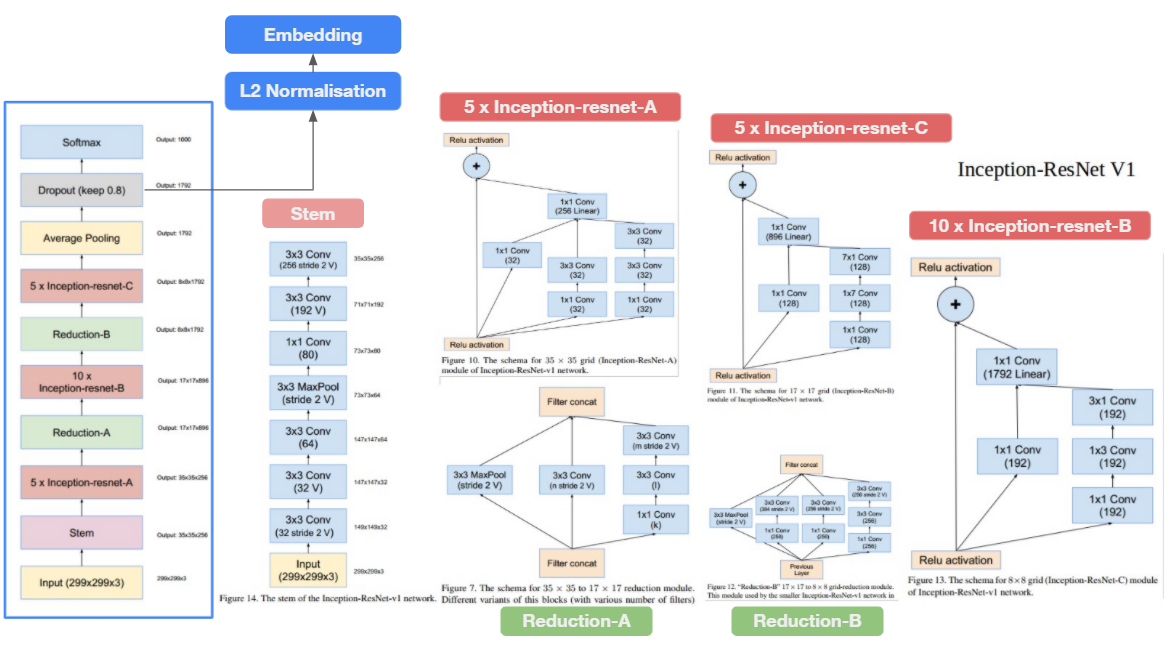
<center>Figure 1. Inception-Resnet v1 Architecture</center>
<center>Source: https://github.com/yudhisteer/Face-Recognition-with-Masks</center>

</br>

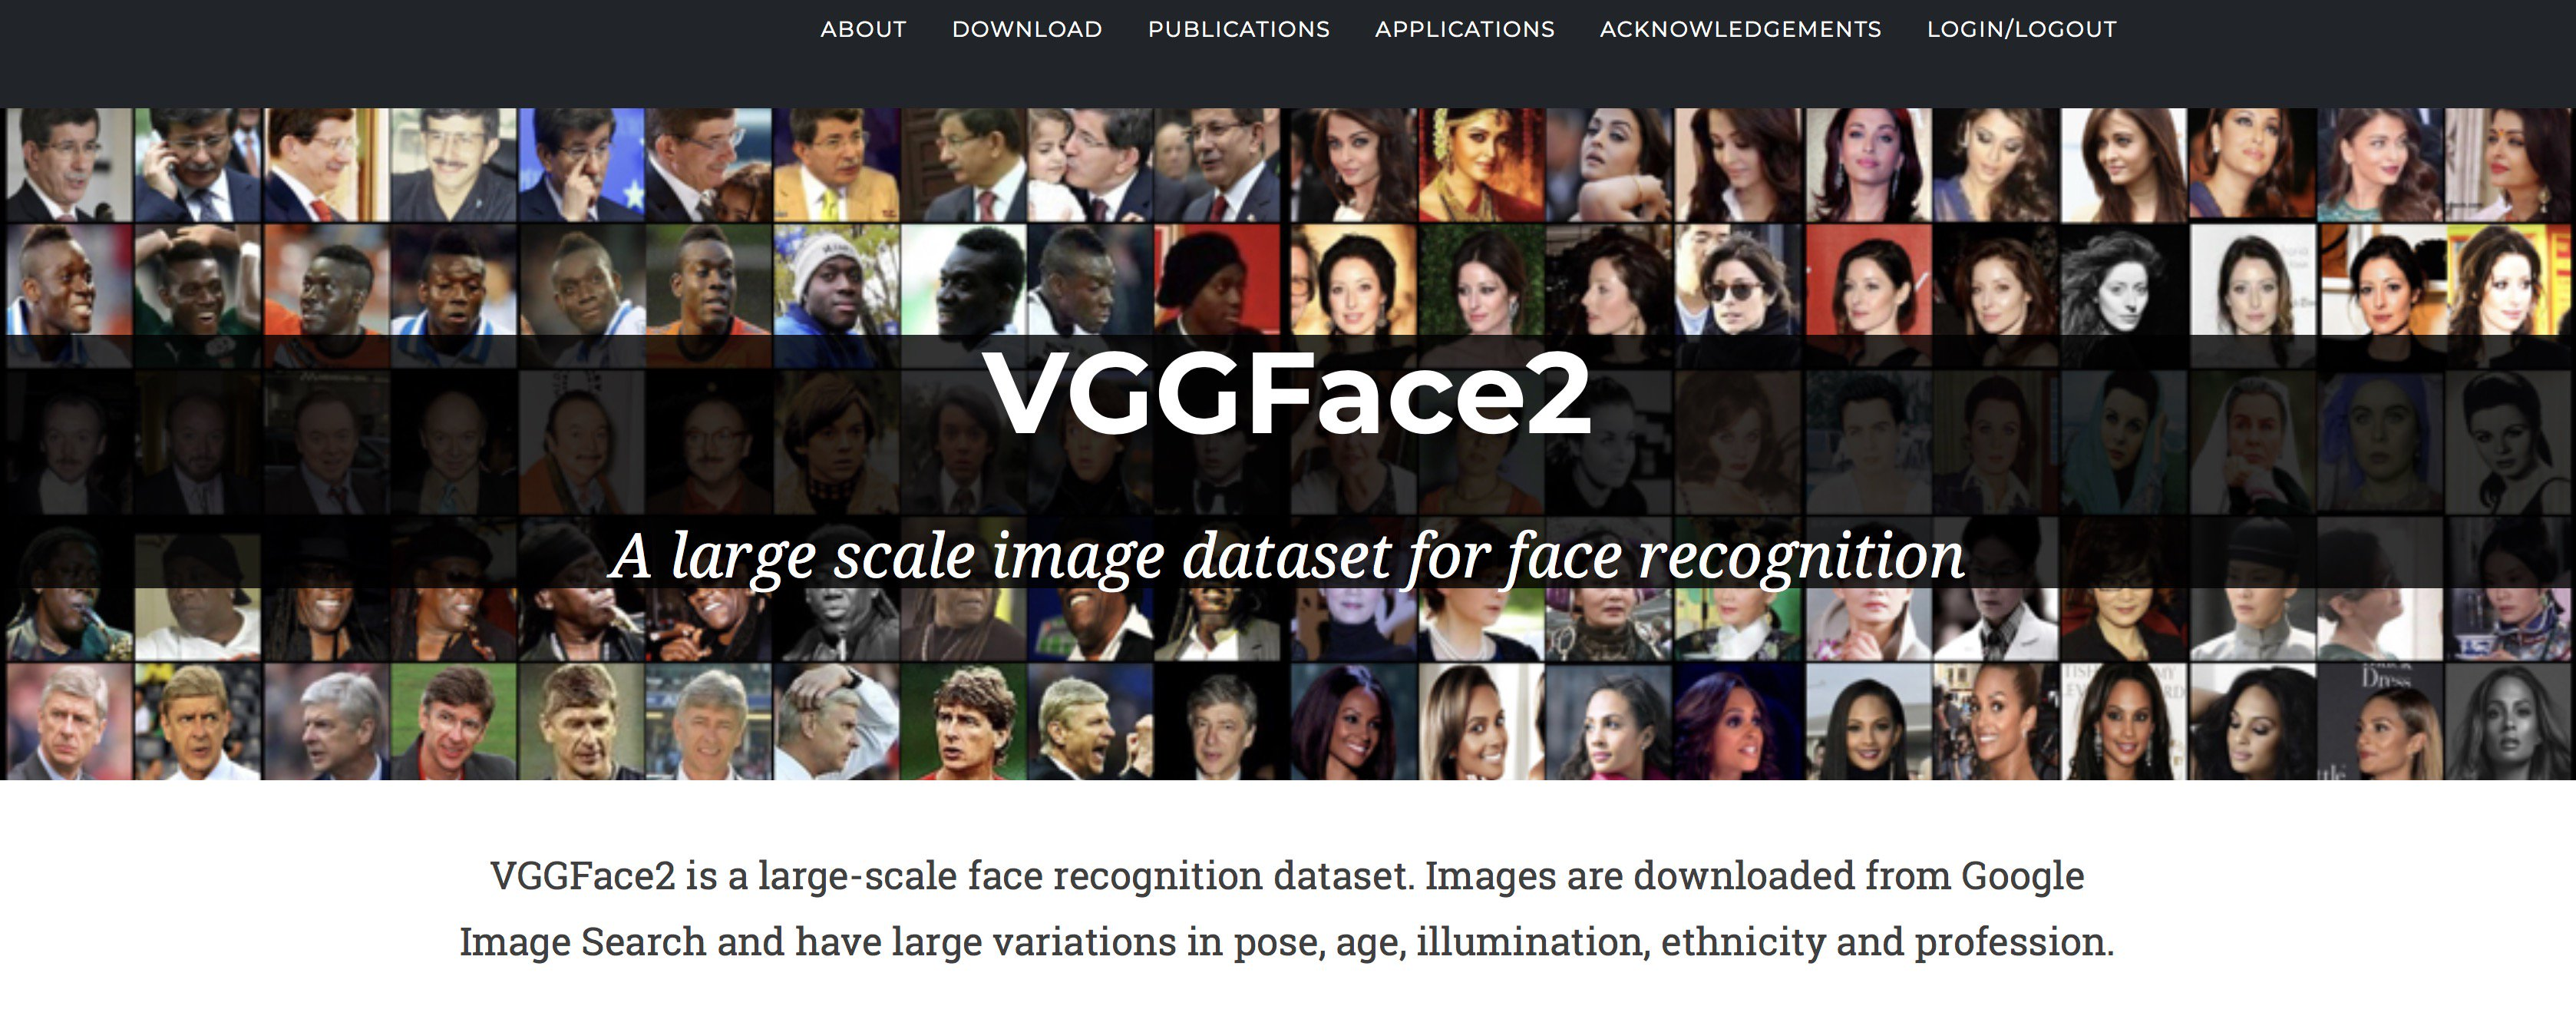
<center>Figure 2. VGGFace2 Dataset</center>
<center>Source: https://twitter.com/WeidiXie/status/1044139012674465792/photo/1</center>

In [10]:
# instantiate the convolutional base
model_conv = (InceptionResnetV1(pretrained='vggface2', 
                          classify=True, 
                          num_classes=len(image_datasets['train'].classes)))

# Feature Extraction

We will freeze all layers except the final one. We need to freeze the parameters so that the gradients are not computed in `backward()`. This is done by setting `requires_grad` to `False`.

In [11]:
for param in model_conv.parameters():
    param.requires_grad = False                        

We can also visualize the model architecture by printing it out.

In [12]:
print(model_conv)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

Based on the model architecture, the last layer of the network is composed of three layers: (last_linear), (last_bn), and (logits).

Although the model is expected to perform well without feature extraction, the logits layer will be modified to increase the model's depth. The effects of this modification are unknown, but it serves as a demonstration of applying concepts we learned in our Machine Learning Class.

We set the device to `GPU` if available and `CPU` if not available, choose the `Cross-Entropy Loss` as our loss function, and use `Adam optimizer` with a `learning rate of 0.001`. Note that the optimization of the parameters will only be applied to the last layer of the model.

In [13]:
# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_conv.logits = nn.Sequential(nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(256, 4, bias=True))

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.logits.parameters(), lr=0.001)

Let's take another look at the CNN summary. Notice that the last layer of the architecture has been updated and now matches the changes we made. 

There are 132,356 trainable parameters and 23,482,624 frozen parameters.

In [14]:
summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

Next, we define a function for the training loop called `train_model` which trains our PyTorch model for a specified number of epochs using a given criterion and optimizer. The default number of epochs is 25, however, to reach convergence, we will increase this to 50.

In [15]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We are now ready to train our model. To recap here's a summary:

1. model_conv - Inception ResNet v1 (a convolutional Neural Network)
2. criterion - Cross Entropy Loss
3. optimizer - Adam Optimizer
4. number of epochs - 50 epochs.

We completed the entire training loop of 50 epochs in just under 2 minutes, with our best validation accuracy at 0.870968.

In [16]:
model_conv = train_model(model_conv, 
                       criterion, 
                       optimizer_conv, 
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.1669 Acc: 0.4839
validation Loss: 1.0587 Acc: 0.6129

Epoch 1/49
----------
train Loss: 0.6683 Acc: 0.8065
validation Loss: 0.9190 Acc: 0.6129

Epoch 2/49
----------
train Loss: 0.5755 Acc: 0.7312
validation Loss: 1.0170 Acc: 0.3548

Epoch 3/49
----------
train Loss: 0.5608 Acc: 0.7634
validation Loss: 0.6073 Acc: 0.6774

Epoch 4/49
----------
train Loss: 0.6924 Acc: 0.6882
validation Loss: 0.7314 Acc: 0.5161

Epoch 5/49
----------
train Loss: 0.5371 Acc: 0.7419
validation Loss: 0.5806 Acc: 0.6452

Epoch 6/49
----------
train Loss: 0.4037 Acc: 0.8602
validation Loss: 0.6463 Acc: 0.5484

Epoch 7/49
----------
train Loss: 0.6272 Acc: 0.7742
validation Loss: 0.3963 Acc: 0.7742

Epoch 8/49
----------
train Loss: 0.4898 Acc: 0.7957
validation Loss: 0.6615 Acc: 0.6452

Epoch 9/49
----------
train Loss: 0.5823 Acc: 0.7419
validation Loss: 0.6886 Acc: 0.7419

Epoch 10/49
----------
train Loss: 0.6666 Acc: 0.7742
validation Loss: 0.8536 Acc: 0.5806

Epoch 11/

# Model Evaluation

Next, we need a baseline to beat. For classification tasks, one of the most common evaluation metrics is the Proportional Chance Criterion ($\mathbf{P}_{CC}$). It is calculated as the proportion of instances in the dataset that belong to the most frequent class, which is the accuracy one could achieve by simply guessing the most frequent class for all instances. It is given by the formula:

\begin{equation} \mathbf{P}_{CC}= (\frac{n_1}{N})^2 + (\frac{n_2}{N})^2 + \cdots + (\frac{n_M}{N})^2 \end{equation}

where $n_M$ is the number of samples at state $M$.

The $\mathbf{P}_{CC}$ is useful to determine whether a classifier performs better than random guessing, especially in cases where the class distribution in the dataset is skewed.

As a heuristic or rule of thumb, a classifier machine learning model is considered highly successful when the test accuracy exceeds 1.25$\mathbf{P}_{CC}$.

We determine our $\mathbf{P}_{CC}$ to be 0.2654, hence we need a test accuracy of at least 0.3318 to say that our model is highly successful in classifying the faces of CPT1.

In [17]:
#Concatenate all datasets
concat_dataset = ConcatDataset([dataloaders['train'].dataset,
                                dataloaders['validation'].dataset,
                                dataloaders['test'].dataset])
concat_dataloader = DataLoader(concat_dataset, shuffle=False)
class_counts = {}

#Get all labels for each datapoint
for inputs, labels in concat_dataloader:
    class_ = int(labels[0])
    if class_counts.get(class_) is None:
        class_counts[class_] = 1
    else:
        class_counts[class_] += 1

        total = 0
val_ = []
for key, value in class_counts.items():
    val_.append(value)    
    total += value

pcc = ((np.array(val_) / total)**2).sum()
acc_beat = 1.25*pcc
print(f'PCC: {pcc:.4f}')
print(f'Accuracy to Beat: {acc_beat}')

PCC: 0.2654
Accuracy to Beat: 0.33178980228928207


Below is a visualization of the dataset's class distribution, where the classes represent the members of Capstone Team 1 (CPT1).

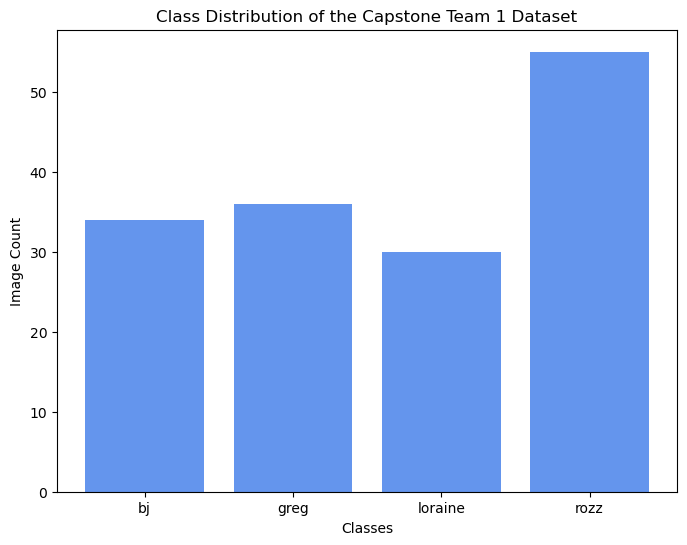

In [18]:
classes = image_datasets['train'].classes
counts = np.array(val_)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(classes, counts, color='cornflowerblue')
ax.set_xlabel('Classes')
ax.set_ylabel('Image Count')
ax.set_title('Class Distribution of the Capstone Team 1 Dataset')

plt.show()

We achieved an outstanding test accuracy of 0.9643, surpassing the 1.25$\mathbf{P}_{CC}$.

In [21]:
def evaluate(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    print("Test Accuracy: {:.4f}".format(correct / total))

In [22]:
evaluate(model_conv, dataloaders['test'])

Test Accuracy: 0.9643


# Visualizing Model Predictions

Next, we want to visualize our model predictions. To do that we define two functions: `imageshow` and `visualize_preds`.

`imageshow` takes an image tensor, undoes normalization, then displays the image.

`visualize_pres` loads a batch of images and their corresponding labels from the test DataLoader, passes them through the model to obtain predicted labels, then displays the images with their `true` and `predicted` labels.

We visualize the first four images in the batch, and the corresponding true and predicted labels:

In [38]:
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_preds(model):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(dataloaders['test']))
    images = images.to(device)
    labels = labels.to(device)

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images.cpu()))
   
    # show the real labels  
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # show the predicted labels 
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


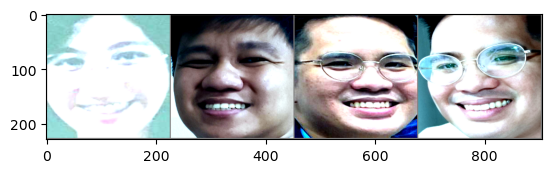

Real labels:  loraine  rozz    bj    bj
Predicted:  loraine  rozz    bj    bj


In [50]:
visualize_preds(model_conv)

# Saving the Model

Finally, we define a code that saves the mean and standard deviations of the dataset, along with the state dictionary of the trained to two separate files.

By doing this, we can easily reload our saved model at any time to make predictions.

In [51]:
#save params
np.savez('mean_std.npz', means=means, stds=stds)
torch.save(model_conv.state_dict(), 'face_recognition_best.pth')

# References

[1] Serengil, S. (2020). Deep Face Detection with MTCNN in Python. Retrieved from https://sefiks.com/2020/09/09/deep-face-detection-with-mtcnn-in-python/

[2] Chintaram, Y. (2021). Automating Attendance System using Face Recognition with Masks. Retrieved from https://github.com/yudhisteer/Face-Recognition-with-Masks

[3] Elgendy, M. (2020, November 10). Deep Learning for Vision Systems. Manning Publications Co.
*Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 2.0.0+cu117 documentation*. (n.d.). Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 2.0.0+cu117 Documentation. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

[4] Alzubaidi, L., Santamaría, J., Manoufali, M., Mohammed, B., Fadhel, M. A., Zhang, J., Al-Timemy, A.H., Al-Shamma, O. & Duan, Y. (2021). MedNet: pre-trained convolutional neural network model for the medical imaging tasks. *arXiv preprint* arXiv:2110.06512.

[5] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 770-778).

[6] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 4700-4708).

[7] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). Imagenet classification with deep convolutional neural networks. *Communications of the ACM*, 60(6), 84-90.

[8] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). Mobilenetv2: Inverted residuals and linear bottlenecks. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 4510-4520).

[9] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. *arXiv preprint* arXiv:1409.1556.

[10] Tan, M., & Le, Q. (2019, May). Efficientnet: Rethinking model scaling for convolutional neural networks. In *International conference on machine learning* (pp. 6105-6114). PMLR.